<a href="https://colab.research.google.com/github/maniParulekar/DataMining/blob/master/PredictFutureSalesKaggle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os, warnings, random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import tensorflow as tf
import tensorflow.keras.layers as L
from tensorflow.keras import optimizers, Sequential, Model

# Set seeds to make the experiment more reproducible.
def seed_everything(seed=0):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'

seed = 0
seed_everything(seed)
warnings.filterwarnings('ignore')
pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [2]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [3]:
#"/content/drive/My Drive/Colab Notebooks/FutureSales/item_categories.csv"
path = "/content/drive/My Drive/Colab Notebooks/FutureSales/item_categories.csv"
itemCats = pd.read_csv(path, dtype={'item_category_name': 'str', 'item_category_id': 'int32'})

In [4]:
itemCats.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84 entries, 0 to 83
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   item_category_name  84 non-null     object
 1   item_category_id    84 non-null     int32 
dtypes: int32(1), object(1)
memory usage: 1.1+ KB


In [5]:
path = "/content/drive/My Drive/Colab Notebooks/FutureSales/"
test = pd.read_csv(path+'test.csv', dtype={'ID': 'int32', 'shop_id': 'int32', 
                                                  'item_id': 'int32'})
items = pd.read_csv(path+ 'items.csv', dtype={'item_name': 'str', 'item_id': 'int32', 
                                                 'item_category_id': 'int32'})
shops = pd.read_csv(path+ 'shops.csv', dtype={'shop_name': 'str', 'shop_id': 'int32'})
sales = pd.read_csv(path+ 'sales_train.csv', parse_dates=['date'], 
                    dtype={'date': 'str', 'date_block_num': 'int32', 'shop_id': 'int32', 
                      'item_id': 'int32', 'item_price': 'float32', 'item_cnt_day': 'int32'})

In [6]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214200 entries, 0 to 214199
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype
---  ------   --------------   -----
 0   ID       214200 non-null  int32
 1   shop_id  214200 non-null  int32
 2   item_id  214200 non-null  int32
dtypes: int32(3)
memory usage: 2.5 MB


In [7]:
sales.describe()

,date_block_num,shop_id,item_id,item_price,item_cnt_day
count,2935849.00,2935849.00,2935849.00,2935849.00,2935849.00
mean,14.57,33.00,10197.23,890.62,1.24
std,9.42,16.23,6324.30,1726.44,2.62
min,0.00,0.00,0.00,-1.00,-22.00
25%,7.00,22.00,4476.00,249.00,1.00
50%,14.00,31.00,9343.00,399.00,1.00
75%,23.00,47.00,15684.00,999.00,1.00
max,33.00,59.00,22169.00,307980.00,2169.00


## **Join the training data in one dataframe**

In [8]:
train = sales.join(items, on='item_id', rsuffix='_').join(shops, on='shop_id', rsuffix='_').join(itemCats, on='item_category_id', rsuffix='_').drop(['item_id_', 'shop_id_', 'item_category_id_'], axis=1)

## **Look at Raw data**

In [9]:
print(f'Train rows: {train.shape[0]}')
print(f'Train columns: {train.shape[1]}')

display(train.head().T)
display(train.describe())

Train rows: 2935849
Train columns: 10


,0,1,2,3,4
date,2013-02-01 00:00:00,2013-03-01 00:00:00,2013-05-01 00:00:00,2013-06-01 00:00:00,2013-01-15 00:00:00
date_block_num,0,0,0,0,0
shop_id,59,25,25,25,25
item_id,22154,2552,2552,2554,2555
item_price,999.00,899.00,899.00,1709.05,1099.00
item_cnt_day,1,1,-1,1,1
item_name,ЯВЛЕНИЕ 2012 (BD),DEEP PURPLE The House Of Blue Light LP,DEEP PURPLE The House Of Blue Light LP,DEEP PURPLE Who Do You Think We Are LP,DEEP PURPLE 30 Very Best Of 2CD (Фирм.)
item_category_id,37,58,58,58,56
shop_name,"Ярославль ТЦ ""Альтаир""","Москва ТРК ""Атриум""","Москва ТРК ""Атриум""","Москва ТРК ""Атриум""","Москва ТРК ""Атриум"""
item_category_name,Кино - Blu-Ray,Музыка - Винил,Музыка - Винил,Музыка - Винил,Музыка - CD фирменного производства


,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_category_id
count,2935849.00,2935849.00,2935849.00,2935849.00,2935849.00,2935849.00
mean,14.57,33.00,10197.23,890.62,1.24,40.00
std,9.42,16.23,6324.30,1726.44,2.62,17.10
min,0.00,0.00,0.00,-1.00,-22.00,0.00
25%,7.00,22.00,4476.00,249.00,1.00,28.00
50%,14.00,31.00,9343.00,399.00,1.00,40.00
75%,23.00,47.00,15684.00,999.00,1.00,55.00
max,33.00,59.00,22169.00,307980.00,2169.00,83.00


# Time period Min Mx

In [10]:
print(f"Min date from train set: {train['date'].min().date()}")
print(f"Max date from train set: {train['date'].max().date()}")

Min date from train set: 2013-01-01
Max date from train set: 2015-12-10


In [11]:
test_shop_ids = test['shop_id'].unique()
test_item_ids = test['item_id'].unique()
# Only shops that exist in test set.
train = train[train['shop_id'].isin(test_shop_ids)]
# Only items that exist in test set.
train = train[train['item_id'].isin(test_item_ids)]

In [12]:
#train.shape
display(train.head().T)
display(train.describe())

,0,10,11,12,13
date,2013-02-01 00:00:00,2013-03-01 00:00:00,2013-05-01 00:00:00,2013-07-01 00:00:00,2013-08-01 00:00:00
date_block_num,0,0,0,0,0
shop_id,59,25,25,25,25
item_id,22154,2574,2574,2574,2574
item_price,999.00,399.00,399.00,399.00,399.00
item_cnt_day,1,2,1,1,2
item_name,ЯВЛЕНИЕ 2012 (BD),DEL REY LANA Born To Die The Paradise Editio...,DEL REY LANA Born To Die The Paradise Editio...,DEL REY LANA Born To Die The Paradise Editio...,DEL REY LANA Born To Die The Paradise Editio...
item_category_id,37,55,55,55,55
shop_name,"Ярославль ТЦ ""Альтаир""","Москва ТРК ""Атриум""","Москва ТРК ""Атриум""","Москва ТРК ""Атриум""","Москва ТРК ""Атриум"""
item_category_name,Кино - Blu-Ray,Музыка - CD локального производства,Музыка - CD локального производства,Музыка - CD локального производства,Музыка - CD локального производства


,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_category_id
count,1224439.00,1224439.00,1224439.00,1224439.00,1224439.00,1224439.00
mean,19.35,32.15,9614.87,1030.12,1.32,40.56
std,9.11,16.47,6299.87,1827.71,3.31,18.61
min,0.00,2.00,30.00,0.50,-16.00,2.00
25%,12.00,19.00,4181.00,299.00,1.00,25.00
50%,21.00,31.00,7856.00,549.00,1.00,38.00
75%,27.00,46.00,15229.00,1199.00,1.00,55.00
max,33.00,59.00,22167.00,59200.00,2169.00,83.00


In [13]:
#test_shop_ids is one dimentional arrray of size (42, 1) and dtype int32
print(test_shop_ids)
test_shop_ids.shape

[ 5  4  6  3  2  7 10 12 28 31 26 25 22 24 21 15 16 18 14 19 42 50 49 53
 52 47 48 57 58 59 55 56 36 37 35 38 34 46 41 44 39 45]


(42,)

In [14]:
print(test_item_ids)
test_item_ids.shape
#test_item_ids is one dimentional arrray of size (5100, 1) :  array([ 5037,  5320,  5233, ..., 15757, 19648,   969], dtype=int32)

[ 5037  5320  5233 ... 15757 19648   969]


(5100,)

In [15]:
test_item_ids

array([ 5037,  5320,  5233, ..., 15757, 19648,   969], dtype=int32)

Data preprocessing
* I'm dropping all features but "item_cnt_day" because I'll be using only it as a univariate time-series.
* We are asked to predict total sales for every product and store in the next month, and our data is given by day, so let's aggregate the data by month.
* Also I'm leaving only monthly "item_cnt" >= 0 and <= 20, as this seems to be the distributions of the test set.

In [16]:
train_monthly = train[['date', 'date_block_num', 'shop_id', 'item_id', 'item_cnt_day']]
train_monthly = train_monthly.sort_values('date').groupby(['date_block_num', 'shop_id', 'item_id'], as_index=False)

In [17]:
train_monthly.head(50)

,date,date_block_num,shop_id,item_id,item_cnt_day
57119,2013-01-01,0,14,2808,2
16686,2013-01-01,0,28,10928,1
16290,2013-01-01,0,28,13511,2
15689,2013-01-01,0,28,5583,1
15680,2013-01-01,0,28,5572,1
...,...,...,...,...,...
2893289,2015-12-10,33,38,17774,1
2893275,2015-12-10,33,38,18511,1
2893265,2015-12-10,33,38,18439,1
2927009,2015-12-10,33,28,17775,1


In [18]:
#train_monthly = train_monthly.agg({'item_cnt_day':['sum']})
#df.groupby(['Outlet_Type','Item_Type']).agg(mean_MRP=('Item_MRP',np.mean),mean_Sales=('Item_Outlet_Sales',np.mean))
train_monthly = train_monthly.agg({'item_cnt_day':'sum'})
train_monthly.head(20)

,date_block_num,shop_id,item_id,item_cnt_day
0,0,2,33,1
1,0,2,482,1
2,0,2,491,1
3,0,2,839,1
4,0,2,1007,3
5,0,2,1010,1
6,0,2,1023,2
7,0,2,1204,1
8,0,2,1224,1
9,0,2,1247,1


In [19]:
train_monthly.describe

<bound method NDFrame.describe of         date_block_num  shop_id  item_id  item_cnt_day
0                    0        2       33             1
1                    0        2      482             1
2                    0        2      491             1
3                    0        2      839             1
4                    0        2     1007             3
...                ...      ...      ...           ...
600154              33       59    22087             6
600155              33       59    22088             2
600156              33       59    22091             1
600157              33       59    22100             1
600158              33       59    22102             1

[600159 rows x 4 columns]>

In [20]:
#train_monthly.to_csv('groupedSumItemCntDat2.csv')

In [21]:

train_monthly.columns = ['date_block_num', 'shop_id', 'item_id', 'item_cnt']
train_monthly = train_monthly.query('item_cnt >= 0 and item_cnt <= 20')
# Label
train_monthly['item_cnt_month'] = train_monthly.sort_values('date_block_num').groupby(['shop_id', 'item_id'])['item_cnt'].shift(-1)

display(train_monthly.head(10).T)
display(train_monthly.describe().T)

,0,1,2,3,4,5,6,7,8,9
date_block_num,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
shop_id,2.00,2.00,2.00,2.00,2.00,2.00,2.00,2.00,2.00,2.00
item_id,33.00,482.00,491.00,839.00,1007.00,1010.00,1023.00,1204.00,1224.00,1247.00
item_cnt,1.00,1.00,1.00,1.00,3.00,1.00,2.00,1.00,1.00,1.00
item_cnt_month,2.00,1.00,1.00,1.00,1.00,1.00,1.00,nan,nan,nan


,count,mean,std,min,25%,50%,75%,max
date_block_num,593829.00,20.18,9.14,0.00,13.00,22.00,28.00,33.00
shop_id,593829.00,32.07,16.90,2.00,19.00,31.00,47.00,59.00
item_id,593829.00,10015.02,6181.82,30.00,4418.00,9171.00,15334.00,22167.00
item_cnt,593829.00,2.10,2.31,0.00,1.00,1.00,2.00,20.00
item_cnt_month,482536.00,2.07,2.17,0.00,1.00,1.00,2.00,20.00


# **Time-series processing**
* As I only need the "item_cnt" feature as a series, I can get that easily by just using a pivot operation.
* This way I'll also get the missing months from each "shop_id" and "item_id", and then replace them with 0 (otherwise would be "nan").

In [22]:
monthly_series = train_monthly.pivot_table(index=['shop_id', 'item_id'], columns='date_block_num',values='item_cnt', fill_value=0).reset_index()
monthly_series.head()

date_block_num,shop_id,item_id,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33
0,2,30,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2,31,0,4,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,2,32,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,2,2,0,2,0,0,1,0,0,0,0,1,0,0
3,2,33,1,0,0,0,0,0,0,0,0,0,2,1,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,1,0,1,0,1,0
4,2,53,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0


In [23]:
#monthly_series.to_csv('shop_ItemGroupedMonthlyItemCnt_widePivot.csv', index=False)

In [24]:
monthly_series.tail(15)

date_block_num,shop_id,item_id,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33
111278,59,22088,5,0,5,3,6,8,7,4,4,0,7,0,1,4,7,5,7,9,10,6,8,7,15,9,6,3,4,3,3,4,7,7,1,2
111279,59,22091,0,0,1,0,2,0,7,2,0,0,1,1,1,0,0,0,0,1,0,2,3,1,1,10,1,0,1,0,0,0,0,0,3,1
111280,59,22092,2,0,5,2,5,0,2,3,5,7,3,7,5,1,0,1,4,1,6,4,7,2,3,3,3,0,3,0,0,0,0,1,0,0
111281,59,22100,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1
111282,59,22102,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,2,0,1
111283,59,22104,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
111284,59,22105,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0
111285,59,22106,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
111286,59,22118,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
111287,59,22139,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0


Currently I have one series (33 months) for each unique pair of "shop_id" and "item_id", but probably would be better to have multiple smaller series for each unique pair, so I'm generating multiple series of size 12 (one year) for each unique pair.

In [25]:
first_month = 20
last_month = 33
serie_size = 12
data_series = []

for index, row in monthly_series.iterrows():
    for month1 in range((last_month - (first_month + serie_size)) + 1):
        serie = [row['shop_id'], row['item_id']]
        for month2 in range(serie_size + 1):
            serie.append(row[month1 + first_month + month2])
        data_series.append(serie)

columns = ['shop_id', 'item_id']
[columns.append(i) for i in range(serie_size)]
columns.append('label')

data_series = pd.DataFrame(data_series, columns=columns)
data_series.info

<bound method DataFrame.info of         shop_id  item_id  0  1  2  3  4  5  6  7  8  9  10  11  label
0             2       30  0  0  0  0  0  0  0  0  0  0   0   0      0
1             2       30  0  0  0  0  0  0  0  0  0  0   0   0      0
2             2       31  0  0  0  0  0  0  0  0  0  0   0   0      0
3             2       31  0  0  0  0  0  0  0  0  0  0   0   0      1
4             2       32  2  2  0  2  0  0  1  0  0  0   0   1      0
...         ...      ... .. .. .. .. .. .. .. .. .. ..  ..  ..    ...
222581       59    22162  0  0  0  0  9  4  1  1  0  0   1   0      0
222582       59    22164  0  0  0  0  0  2  1  2  0  0   1   0      0
222583       59    22164  0  0  0  0  2  1  2  0  0  1   0   0      0
222584       59    22167  0  0  0  0  0  0  0  0  0  0   0   0      0
222585       59    22167  0  0  0  0  0  0  0  0  0  0   0   0      0

[222586 rows x 15 columns]>

In [26]:
#data_series.to_csv('shop_ItemGroupedItemCntsIn12MonthSeries.csv', index=False)

 **Dropping identifier columns as we don't need them anymore.**

In [27]:
data_series = data_series.drop(['item_id', 'shop_id'], axis=1)

**TRain and Validation sets**

In [ ]:
labels = data_series['label']
data_series.drop('label', axis=1, inplace=True)
train, valid, Y_train, Y_valid = train_test_split(data_series, labels.values, test_size=0.10, random_state=0)

In [30]:
train, valid, Y_train, Y_valid = train_test_split(data_series, labels.values, test_size=0.10, random_state=50)

In [31]:
print("Train set", train.shape)
print("Validation set", valid.shape)
train.head()

Train set (200327, 12)
Validation set (22259, 12)


,0,1,2,3,4,5,6,7,8,9,10,11
197402,0,1,0,0,2,0,0,1,0,0,0,0
51148,0,0,0,0,0,0,0,1,0,1,1,0
105119,0,0,0,0,0,0,0,0,0,0,0,0
56231,0,0,0,2,0,0,0,0,1,0,3,2
156632,0,0,1,3,2,1,1,0,0,0,1,0


# Reshape data.
*   Time-series shape (data points, time-steps, features).





In [32]:
X_train = train.values.reshape((train.shape[0], train.shape[1], 1))
X_valid = valid.values.reshape((valid.shape[0], valid.shape[1], 1))

print("Train set reshaped", X_train.shape)
print("Validation set reshaped", X_valid.shape)

Train set reshaped (200327, 12, 1)
Validation set reshaped (22259, 12, 1)


# First let's begin with how a regular RNN time-series approach could be.
*   Regular LSTM model.




In [33]:
serie_size =  X_train.shape[1] # 12
n_features =  X_train.shape[2] # 1

epochs = 20
batch = 128
lr = 0.0001

lstm_model = Sequential()
lstm_model.add(L.LSTM(10, input_shape=(serie_size, n_features), return_sequences=True))
lstm_model.add(L.LSTM(6, activation='relu', return_sequences=True))
lstm_model.add(L.LSTM(1, activation='relu'))
lstm_model.add(L.Dense(10, kernel_initializer='glorot_normal', activation='relu'))
lstm_model.add(L.Dense(10, kernel_initializer='glorot_normal', activation='relu'))
lstm_model.add(L.Dense(1))
lstm_model.summary()

adam = optimizers.Adam(lr)
lstm_model.compile(loss='mse', optimizer=adam)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 12, 10)            480       
_________________________________________________________________
lstm_1 (LSTM)                (None, 12, 6)             408       
_________________________________________________________________
lstm_2 (LSTM)                (None, 1)                 32        
_________________________________________________________________
dense (Dense)                (None, 10)                20        
_________________________________________________________________
dense_1 (Dense)              (None, 10)                110       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 11        
Total params: 1,061
Trainable params: 1,061
Non-trainable params: 0
______________________________________________________

In [34]:
lstm_history = lstm_model.fit(X_train, Y_train, 
                              validation_data=(X_valid, Y_valid), 
                              batch_size=batch, 
                              epochs=epochs, 
                              verbose=2)

Epoch 1/20
1566/1566 - 66s - loss: 1.4991 - val_loss: 1.3456
Epoch 2/20
1566/1566 - 68s - loss: 1.3259 - val_loss: 1.2840
Epoch 3/20
1566/1566 - 67s - loss: 1.2723 - val_loss: 1.2439
Epoch 4/20
1566/1566 - 67s - loss: 1.2320 - val_loss: 1.2108
Epoch 5/20
1566/1566 - 67s - loss: 1.2015 - val_loss: 1.1750
Epoch 6/20
1566/1566 - 66s - loss: 1.1751 - val_loss: 1.1652
Epoch 7/20
1566/1566 - 66s - loss: 1.1701 - val_loss: 1.1610
Epoch 8/20
1566/1566 - 63s - loss: 1.1678 - val_loss: 1.1554
Epoch 9/20
1566/1566 - 64s - loss: 1.1662 - val_loss: 1.1555
Epoch 10/20
1566/1566 - 67s - loss: 1.1648 - val_loss: 1.1518
Epoch 11/20
1566/1566 - 67s - loss: 1.1640 - val_loss: 1.1507
Epoch 12/20
1566/1566 - 69s - loss: 1.1630 - val_loss: 1.1512
Epoch 13/20
1566/1566 - 68s - loss: 1.1623 - val_loss: 1.1512
Epoch 14/20
1566/1566 - 67s - loss: 1.1619 - val_loss: 1.1517
Epoch 15/20
1566/1566 - 67s - loss: 1.1616 - val_loss: 1.1489
Epoch 16/20
1566/1566 - 66s - loss: 1.1613 - val_loss: 1.1484
Epoch 17/20
1566/

Autoencoder
*   Now we will build an autoencoder to learn how to reconstruct the input, this way it internally learns the best way to represent the input in lower dimensions.
*   The reconstruct model is composed of an encoder and a decoder, the encoder is responsible for learning how to represent the input into lower dimensions and the decoder learns how to rebuild the smaller representations into the input again.
*   Here is a structural representations of an autoencoder


*   After the models is trained we can keep only the encoder part and we'll have a model that is able to do what we want.

# LSTM Autoencoder.

In [35]:
encoder_decoder = Sequential()
encoder_decoder.add(L.LSTM(serie_size, activation='relu', input_shape=(serie_size, n_features), return_sequences=True))
encoder_decoder.add(L.LSTM(6, activation='relu', return_sequences=True))
encoder_decoder.add(L.LSTM(1, activation='relu'))
encoder_decoder.add(L.RepeatVector(serie_size))
encoder_decoder.add(L.LSTM(serie_size, activation='relu', return_sequences=True))
encoder_decoder.add(L.LSTM(6, activation='relu', return_sequences=True))
encoder_decoder.add(L.TimeDistributed(L.Dense(1)))
encoder_decoder.summary()

adam = optimizers.Adam(lr)
encoder_decoder.compile(loss='mse', optimizer=adam)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 12, 12)            672       
_________________________________________________________________
lstm_4 (LSTM)                (None, 12, 6)             456       
_________________________________________________________________
lstm_5 (LSTM)                (None, 1)                 32        
_________________________________________________________________
repeat_vector (RepeatVector) (None, 12, 1)             0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 12, 12)            672       
_________________________________________________________________
lstm_7 (LSTM)                (None, 12, 6)             456       
_________________________________________________________________
time_distributed (TimeDistri (None, 12, 1)            

In [36]:
encoder_decoder_history = encoder_decoder.fit(X_train, X_train, 
                                              batch_size=batch, 
                                              epochs=epochs, 
                                              verbose=2)

Epoch 1/20
1566/1566 - 145s - loss: 1.5547
Epoch 2/20
1566/1566 - 145s - loss: 1.1498
Epoch 3/20
1566/1566 - 146s - loss: 1.0592
Epoch 4/20
1566/1566 - 146s - loss: 1.0280
Epoch 5/20
1566/1566 - 148s - loss: 1.0034
Epoch 6/20
1566/1566 - 148s - loss: 0.9820
Epoch 7/20
1566/1566 - 149s - loss: 0.9663
Epoch 8/20
1566/1566 - 144s - loss: 0.9587
Epoch 9/20
1566/1566 - 146s - loss: 0.9557
Epoch 10/20
1566/1566 - 147s - loss: 0.9495
Epoch 11/20
1566/1566 - 147s - loss: 0.9411
Epoch 12/20
1566/1566 - 150s - loss: 0.9345
Epoch 13/20
1566/1566 - 144s - loss: 0.9272
Epoch 14/20
1566/1566 - 148s - loss: 0.9242
Epoch 15/20
1566/1566 - 148s - loss: 0.9184
Epoch 16/20
1566/1566 - 145s - loss: 0.9140
Epoch 17/20
1566/1566 - 147s - loss: 0.9276
Epoch 18/20
1566/1566 - 147s - loss: 0.9322
Epoch 19/20
1566/1566 - 148s - loss: 0.9196
Epoch 20/20
1566/1566 - 148s - loss: 0.9067


You should be aware that the better the autoencoder is able to reconstruct the input the better it internally encodes the input, in other words if we have a good autoencoder we probably will have an equally good encoder.
*  Let's take a look at the layers of the encoder_decoder model:

In [37]:
rpt_vector_layer = Model(inputs=encoder_decoder.inputs, outputs=encoder_decoder.layers[3].output)
time_dist_layer = Model(inputs=encoder_decoder.inputs, outputs=encoder_decoder.layers[5].output)
encoder_decoder.layers

#About the autoencoder layers
### LSTM
*   This is just a regular LSTM layer, a layer that is able to receive sequence data and learn based on it nothing much to talk about.

# RepeatVector layer
*   Here is something we don't usually see, this layers basically repeats it's input "n" times, the reason to use it is because the last layers from the encoder part (the layer with one neuron) don't return sequences, so it does not outputs a sequenced data, this way we can't just add another LSTM layer after it, we need a way to turn this output into a sequence of the same time-steps of the model input, this is where "RepeatVector" layers comes in.
*   Let's see what it outputs.

In [39]:
rpt_vector_layer_output = rpt_vector_layer.predict(X_train[:1])
print('Repeat vector output shape', rpt_vector_layer_output.shape)
print('Repeat vector output sample')
print(rpt_vector_layer_output[0])

Repeat vector output shape (1, 12, 1)
Repeat vector output sample
[[3.567359]
 [3.567359]
 [3.567359]
 [3.567359]
 [3.567359]
 [3.567359]
 [3.567359]
 [3.567359]
 [3.567359]
 [3.567359]
 [3.567359]
 [3.567359]]


As you can see this is just the same value repeated some times to match the same shape of the model input.

# TimeDistributed layer
*   This layer is more common, sometimes is used when you want to mix RNN layers with other kind of layers.
*   We could output the model with another LSTM layer with one neuron and "return_sequences=True" parameter, but using a "TimeDistributed" layer wrapping a "Dense" layer we will have the same weights for each outputted time-step.

In [40]:
time_dist_layer_output = time_dist_layer.predict(X_train[:1])
print('Time distributed output shape', time_dist_layer_output.shape)
print('Time distributed output sample')
print(time_dist_layer_output[0])

Time distributed output shape (1, 12, 6)
Time distributed output sample
[[9.7219162e-02 0.0000000e+00 4.3158818e-02 8.2459301e-02 5.7572499e-02
  9.7579770e-02]
 [2.2280194e-01 0.0000000e+00 1.3449687e-01 1.1660421e-01 1.1098659e-01
  2.3652729e-01]
 [2.7853993e-01 0.0000000e+00 2.6184911e-01 6.6961333e-02 1.5117174e-01
  3.4960291e-01]
 [1.8573985e-01 0.0000000e+00 4.0055460e-01 3.4867603e-02 1.7170012e-01
  4.1348156e-01]
 [5.6165267e-02 0.0000000e+00 5.3045595e-01 1.6697813e-02 1.7816319e-01
  4.2419681e-01]
 [1.4332605e-02 0.0000000e+00 6.3211495e-01 7.5954059e-03 1.7306440e-01
  3.7337512e-01]
 [3.1847889e-03 0.0000000e+00 6.8839222e-01 3.4220051e-03 1.5511943e-01
  2.8485981e-01]
 [6.6928443e-04 0.0000000e+00 7.0217061e-01 1.5673244e-03 1.2778285e-01
  1.9780043e-01]
 [1.4370460e-04 0.0000000e+00 6.8655151e-01 7.3519466e-04 9.5639892e-02
  1.3492924e-01]
 [3.3203014e-05 0.0000000e+00 6.5589529e-01 3.5226872e-04 6.8454064e-02
  9.9122450e-02]
 [8.4060948e-06 0.0000000e+00 6.206023

## Defining the encoding model.
* What I want is to encode the whole series into a single value, so I need the output from the layer with a single neuron (in this case it's the third LSTM layer).
*   I'll take only the encoding part of the model and define it as a new one.

In [41]:
encoder = Model(inputs=encoder_decoder.inputs, outputs=encoder_decoder.layers[2].output)

## Now let's encode the train and validation time-series

In [42]:
train_encoded = encoder.predict(X_train)
validation_encoded = encoder.predict(X_valid)
print('Encoded time-series shape', train_encoded.shape)
print('Encoded time-series sample', train_encoded[0])

Encoded time-series shape (200327, 1)
Encoded time-series sample [3.5673609]


### Add new encoded features to the train and validation sets.

In [43]:
train['encoded'] = train_encoded
train['label'] = Y_train

valid['encoded'] = validation_encoded
valid['label'] = Y_valid

train.head(10)

,0,1,2,3,4,5,6,7,8,9,10,11,encoded,label
197402,0,1,0,0,2,0,0,1,0,0,0,0,3.57,0
51148,0,0,0,0,0,0,0,1,0,1,1,0,2.89,0
105119,0,0,0,0,0,0,0,0,0,0,0,0,0.23,0
56231,0,0,0,2,0,0,0,0,1,0,3,2,10.36,0
156632,0,0,1,3,2,1,1,0,0,0,1,0,6.38,0
95581,0,0,0,0,0,0,0,0,0,0,0,0,0.23,0
69395,0,0,0,0,0,0,0,0,0,0,0,1,0.85,0
47285,0,0,0,0,0,0,0,0,1,0,0,0,1.08,1
178824,0,0,0,0,0,0,0,0,0,0,0,1,0.85,1
119158,0,0,0,0,0,0,0,0,0,0,0,0,0.23,2


## Now we can use the new encoded feature that is a representation of the whole time-series and train a "less complex" model that does not receives sequenced data as input.

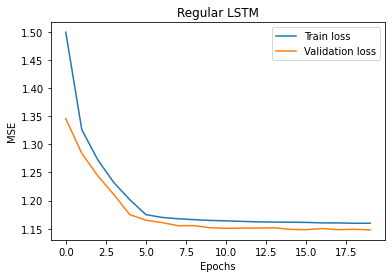

In [46]:
#fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True,figsize=(22,7))

plt.plot(lstm_history.history['loss'], label='Train loss')
plt.plot(lstm_history.history['val_loss'], label='Validation loss')
plt.legend(loc='best')
plt.title('Regular LSTM')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.show()

## Regular LSTM on train and validation.

In [47]:
lstm_train_pred = lstm_model.predict(X_train)
lstm_val_pred = lstm_model.predict(X_valid)
print('Train rmse:', np.sqrt(mean_squared_error(Y_train, lstm_train_pred)))
print('Validation rmse:', np.sqrt(mean_squared_error(Y_valid, lstm_val_pred)))

Train rmse: 1.0763282759874446
Validation rmse: 1.0714031106777926


## Build test set
*  Since we have two models I'll build test sets to apply on both of them.

In [48]:
latest_records = monthly_series.drop_duplicates(subset=['shop_id', 'item_id'])
X_test = pd.merge(test, latest_records, on=['shop_id', 'item_id'], how='left', suffixes=['', '_'])
X_test.fillna(0, inplace=True)
X_test.drop(['ID', 'item_id', 'shop_id'], axis=1, inplace=True)
X_test.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33
0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,1.00,2.00,2.00,0.00,0.00,0.00,1.00,1.00,1.00,3.00,1.00,0.00
1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,3.00,2.00,0.00,1.00,3.00,1.00
3,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00
4,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


# Regular LSTM model test predictions
* For the regular LSTM model we just need the last 12 months, because that's our series input size

In [49]:
X_test = X_test[[(i + (34 - serie_size)) for i in range(serie_size)]]
X_test.head()

,22,23,24,25,26,27,28,29,30,31,32,33
0,1.00,2.00,2.00,0.00,0.00,0.00,1.00,1.00,1.00,3.00,1.00,0.00
1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,0.00,0.00,0.00,0.00,0.00,0.00,3.00,2.00,0.00,1.00,3.00,1.00
3,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00
4,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


## Reshape Test data.
Time-series shape (data points, time-steps, features).

In [50]:
X_test_reshaped = X_test.values.reshape((X_test.shape[0], X_test.shape[1], 1))
print(X_test_reshaped.shape)

(214200, 12, 1)


# Making predictions on Test

In [51]:
lstm_test_pred = lstm_model.predict(X_test_reshaped)

In [52]:
lstm_prediction = pd.DataFrame(test['ID'], columns=['ID'])
lstm_prediction['item_cnt_month'] = lstm_test_pred.clip(0., 20.)
lstm_prediction.to_csv('KaggleFutureSalesSubmission.csv', index=False)
lstm_prediction.head(10)

,ID,item_cnt_month
0,0,0.56
1,1,0.47
2,2,0.84
3,3,0.16
4,4,0.47
5,5,0.45
6,6,0.98
7,7,0.18
8,8,1.22
9,9,0.47
